# Model evaluation

## Settings

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import helpers.settings as sts
sts.print_settings(sts)

BEST_ESTIMATOR_FILENAME : best_estimator_0.0.1.pkl
DATASET_TRAIN_FILENAME : dataset_train.parquet
DATASET_VALIDATION_FILENAME : dataset_validation.parquet
ETL_VERSION : 0.0.1
MODEL_FILENAME : model.pkl
MODEL_VERSION : 0.0.1
PREPROCESSOR_FILENAME : preprocessor_0.0.1.pkl
TRAINED_BEST_ESTIMATOR_FILENAME : trained_best_estimator_0.0.1.pkl
color : <class 'helpers.settings.color'>
print_settings : <function print_settings at 0x7ffbe09b1c10>



## Imports

In [4]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import (
    classification_report,
    plot_precision_recall_curve,
    precision_recall_curve,
    average_precision_score,
    plot_confusion_matrix,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
from sklearn import tree
# Export as dot file
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
import seaborn as sns
import shap

## Load validation dataset

In [5]:
df_validation = pd.read_parquet(f"data/{sts.DATASET_VALIDATION_FILENAME}")
df_train = pd.read_parquet(f"data/{sts.DATASET_TRAIN_FILENAME}")

In [6]:
X_validation = df_validation.iloc[:,:-1]
y_validation = df_validation.iloc[:,-1]

## Load trained best estimator

In [7]:
with open(f"artifacts/{sts.TRAINED_BEST_ESTIMATOR_FILENAME}","rb") as file:
    best_estimator = pickle.load(file)    

In [8]:
y_proba = best_estimator.predict_proba(X_validation)[:,1]

In [9]:
y_pred = np.where(y_proba > 0.5, 1, 0)

In [10]:
print(classification_report(y_validation, y_pred, target_names=["good","bad"]))

              precision    recall  f1-score   support

        good       1.00      1.00      1.00      5396
         bad       0.90      0.85      0.87        73

    accuracy                           1.00      5469
   macro avg       0.95      0.92      0.94      5469
weighted avg       1.00      1.00      1.00      5469



In [11]:
y_validation.value_counts()

0    5396
1      73
Name: LABEL, dtype: int64

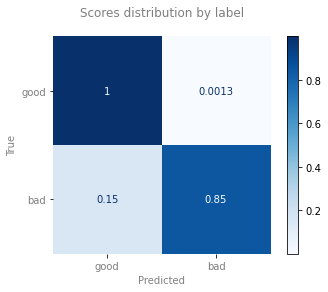

In [12]:
plot_confusion_matrix(best_estimator, X_validation, y_validation, normalize="true", display_labels=["good","bad"], cmap="Blues")
plt.title("Normalized confusion matrix", pad=20)
sns.despine(bottom = True, left = True)
plt.title("Scores distribution by label", pad=20, color="#7f7f7f")
plt.xticks(color="#7f7f7f")
plt.yticks(color="#7f7f7f")
plt.ylabel("True", color="#7f7f7f")
plt.xlabel("Predicted", color="#7f7f7f");

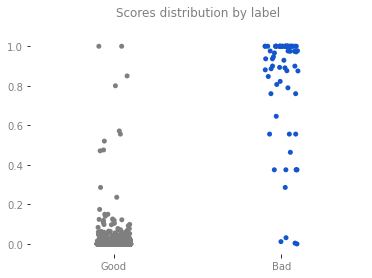

In [13]:
g = sns.stripplot(
    x=y_validation,
    y=y_proba,
    palette=["#7f7f7f","#1355cc"],
)
plt.title("Scores distribution by label", pad=20, color="#7f7f7f")
plt.xticks(color="#7f7f7f")
plt.yticks(color="#7f7f7f")
plt.xlabel(None)
sns.despine(bottom = True, left = True)
plt.xticks([0,1],["Good","Bad"]);

In [14]:
explainer = shap.TreeExplainer(best_estimator["clf"])

In [15]:
X_transformed = pd.DataFrame(best_estimator["preprocessor"].transform(df_train[best_estimator["preprocessor"].initial_features]), columns=best_estimator["preprocessor"].final_features)

In [16]:
shap_values = explainer.shap_values(X_transformed)

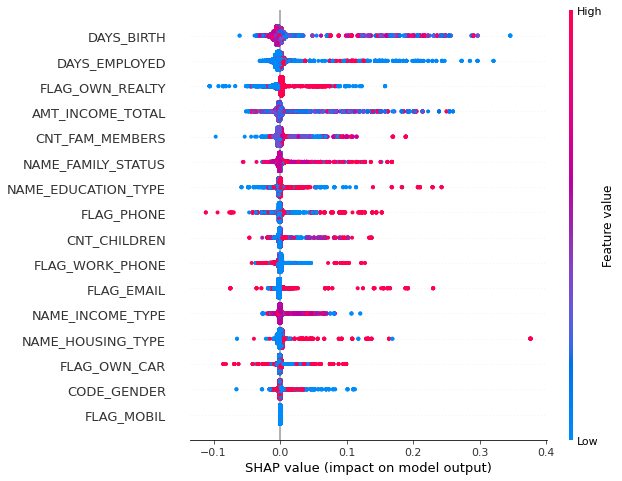

In [17]:
shap.summary_plot(shap_values[1], X_transformed, plot_type="dot")